<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GoldStandard/golds_Voice_randose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Principle of relevant information for MA

$$\min_X H(X)+\lambda D_{KL}(X||X_o) = H(X)+\lambda (H(X;X_o) - H(X)))$$

$$\min_X (1-\lambda)H(X)+\lambda H(X;X_o)$$

## Principle of relevant information for RCDNN MA

$$\min_\theta \sum_n \sum_{r\in\Psi_n} (1-\lambda^r_n(\theta))H(\hat{\mathbf{y}}_n(\theta))+\lambda_n^r(\theta)H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))$$

${\mathbf{y}}^r_n\in[0,1]^K$: 1-K label vector for the r-th annotator

$\hat{{\mathbf{y}}}_n\in[0,1]^K$: 1-K label vector for the RCDNN prediction

$\lambda_n^r(\theta)\in[0,1]$: annotator reliability

$\theta$: RCDNN parameters (network weights and bias)

$H(\hat{\mathbf{y}}_n(\theta))= \sum_k \hat{y}_{n,k}\log\left(\hat{y}_{n,k}\right)$: marginal entropy

$H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta)) = \sum_k {y}^r_{n,k}\log\left(\hat{y}_{n,k}\right)$: cross-entropy

Then:


$$\min_\theta \sum_n\left(\sum_r \lambda_n^r(\theta)H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\lambda_n^r(\theta)\right)\right)$$



## Matrix-based computation

$$\min_\theta \text{tr}\left(\mathbf{\Lambda}^\top\mathbf{H}_{y,\hat{y}}\right) + \mathbf{H}_{\hat{y}}^\top(\mathbf{1}_N\mathbf{1}^\top_R-\mathbf{\Lambda})\mathbf{1}_R$$

$\mathbf{1}_N\in\mathbb{R}^{N\times 1}$, $\mathbf{1}_R\in\mathbb{R}^{R\times 1}$

$\mathbf{\Lambda}\in[0,1]^{N\times R}$

$\mathbf{H}_{\hat{y}}\in\mathbb{R}^{N\times 1}$

$\mathbf{H}_{y,\hat{y}}\in\mathbb{R}^{N\times R}$

#!pip install tensorflow==2.7.0
#!pip install scikeras

# Subclassing for GCCE

In [172]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):

        initializer = tf.keras.initializers.GlorotNormal(seed=100)
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "RMS":
            opt = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        input_l_b = tf.keras.layers.BatchNormalization()(input_l)        
        input_l_do = tf.keras.layers.Dropout(rate=self.dropout)(input_l_b)   
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*1*(self.K+self.R)),activation='selu',name='h1',  bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l_do)#argumento de entrada
        #h1 = tf.keras.layers.BatchNormalization()(h1)        
        h1 = tf.keras.layers.AlphaDropout(rate=self.dropout)(h1)      
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',  bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        #h2 = tf.keras.layers.BatchNormalization()(h2)     
        dout = tf.keras.layers.AlphaDropout(rate=self.dropout)(h2)
        #capa de salida
        
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output',  bias_initializer='zeros', kernel_initializer=initializer,
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics="accuracy")
         
            
        callback1 = tf.keras.callbacks.TerminateOnNaN()
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
        #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
        callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)
            
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split, callbacks = [callback1, callback2],
                                      batch_size=self.batch_size,verbose=self.verbose)
        

        self.model.summary() 
        return self
 
  
   
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
    
    def predict_proba(self, X, num_samples):
        preds = [self.model(X, training=True) for _ in range(num_samples)]
        return np.stack(preds).mean(axis=0)

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [173]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2023-02-09 20:58:24--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 74.125.196.138, 74.125.196.102, 74.125.196.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.196.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6nhtbpk53mqco53ueld9unhmf4r96a2f/1675976250000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=6f402083-6bdf-4810-8f4a-ab4bc380df80 [following]
--2023-02-09 20:58:24--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6nhtbpk53mqco53ueld9unhmf4r96a2f/1675976250000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=6f402083-6bdf-4810-8f4a-ab4bc380df80
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 74.125.196.132, 

In [174]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

# Load Data

In [175]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Voice' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


path_ = 'MADatasets/'+ database+ '.mat' 
Xdata = sio.loadmat(path_)
Xdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X1', 'X2', 'X3', 'YA', 'YB', 'YG', 'YR', 'YS', 'y', 'idxte', 'idxtr'])

In [176]:

X1train = Xdata['X1']
X2train = Xdata['X2']
X3train = Xdata['X3']

Ytrue =  Xdata['y']
YA =  Xdata['YA']
YB =  Xdata['YB']
YR=  Xdata['YR']
YG =  Xdata['YG']
YS =  Xdata['YS']
 
print('X1train',X1train.shape, 'X2train',X2train.shape, 'X3train',X3train.shape)
print('YA',YA.shape, 'YB',YB.shape, 'YG',YG.shape,'YR',YR.shape, 'YS',YS.shape)  #,    'Ytrain',Ytrain.shape, 'Ytest',Ytest.shape)
print('Ytrue', Ytrue.shape)
 

X1train (218, 13) X2train (218, 26) X3train (218, 39)
YA (218, 4) YB (218, 4) YG (218, 3) YR (218, 4) YS (218, 4)
Ytrue (218, 1)


In [177]:
YR[YR>=1] =1
Y = YR 

X = X1train
#regresor logistico

In [178]:
test_index = Xdata['idxte']
train_index = Xdata['idxtr']

In [179]:
 
X_train, X_test,Y_train,Y_test = X[train_index[:,2],:], X[test_index[:,2],:],Y[train_index[:,2],:], Y[test_index[:,2],:]
Y_true_train, Y_true_test = Ytrue[train_index[:,2]].reshape(-1,1), Ytrue[test_index[:,2]].reshape(-1,1)

In [180]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [181]:

from sklearn.linear_model import LogisticRegression
 
clf = LogisticRegression(random_state=0).fit(X_train, Y_true_train.ravel())
 
clf.score(X_test, Y_true_test.ravel())


0.9230769230769231

# Split data

In [182]:
import numpy.matlib
# from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
# Ns = 1
# ss =StratifiedShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
# for train_index, test_index in ss.split(X,Ytrue):
#     print(test_index)
#     X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
#     Y_true_train, Y_true_test = Ytrue[train_index].reshape(-1,1), Ytrue[test_index].reshape(-1,1)
# print(X_train.shape, Y_train.shape, Y_true_train.shape)

In [183]:
# for i in range(Y.shape[1]):
#     print('annotator',i+1)
   
#     unique, counts = np.unique(Y_train[:,i], return_counts=True)
#     plt.figure()
#     plt.bar(unique, counts)
#     unique, counts = np.unique(Y_test[:,i], return_counts=True)
#     plt.bar(unique, counts)

#     plt.title('Class Frequency for Y_true')
#     plt.xlabel('Class')
#     plt.ylabel('Frequency')


# Apply MinMaxScaler

In [184]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# Testing the Class 


iteration: 0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization (BatchN  (None, 13)               52        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                                 
 alpha_dropout (AlphaDropout  (None, 39)               0         
 )                                                               
                                                                 
 h2 (Dense)                  (None, 39)         

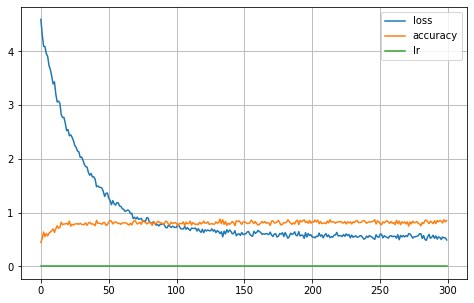

Validation montecarlo ACC: 0.9077
3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9618
Validation Balanced_ACC: 0.8273
Validation Normalized MI: 0.4944
Validation Adjusted MI: 0.4847
Validation aUc: 0.9136
iteration: 1
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_1 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

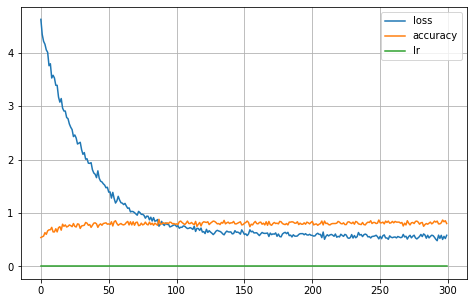

Validation montecarlo ACC: 0.9077
3/3 [==============================] - 0s 5ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9655
Validation Balanced_ACC: 0.8273
Validation Normalized MI: 0.4944
Validation Adjusted MI: 0.4847
Validation aUc: 0.9136
iteration: 2
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_2 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

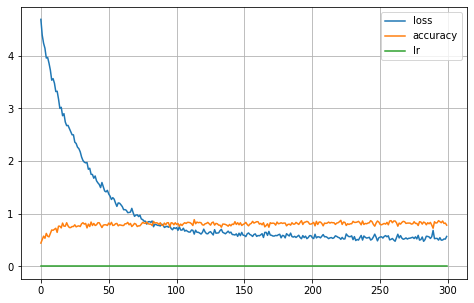

Validation montecarlo ACC: 0.9077
3/3 [==============================] - 0s 5ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9655
Validation Balanced_ACC: 0.8273
Validation Normalized MI: 0.4944
Validation Adjusted MI: 0.4847
Validation aUc: 0.9136
iteration: 3
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_3 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

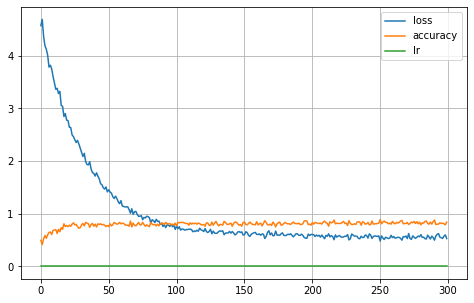

Validation montecarlo ACC: 0.9077
3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9655
Validation Balanced_ACC: 0.8273
Validation Normalized MI: 0.4944
Validation Adjusted MI: 0.4847
Validation aUc: 0.9136
iteration: 4
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_4 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

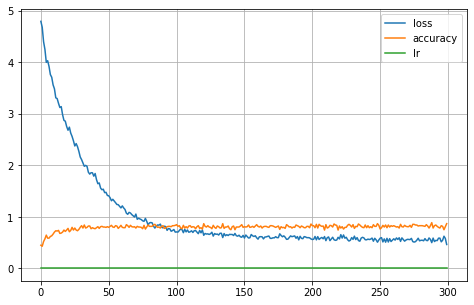

Validation montecarlo ACC: 0.8923
3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9636
Validation Balanced_ACC: 0.8273
Validation Normalized MI: 0.4944
Validation Adjusted MI: 0.4847
Validation aUc: 0.9136
iteration: 5
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_5 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

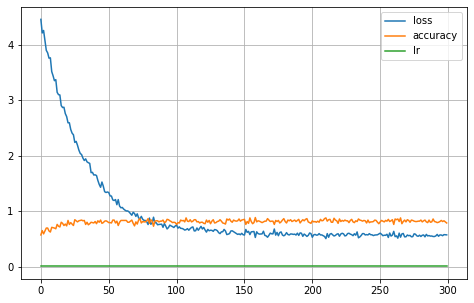

Validation montecarlo ACC: 0.9077
3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9385
Validation aUc_Sklearn: 0.9600
Validation Balanced_ACC: 0.9273
Validation Normalized MI: 0.6323
Validation Adjusted MI: 0.6255
Validation aUc: 0.9636
iteration: 6
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_6 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

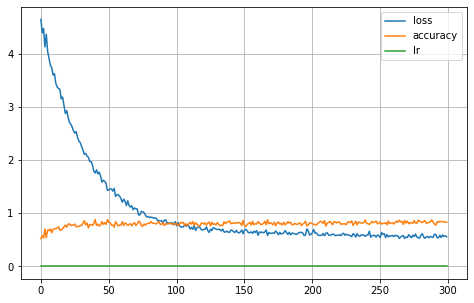

Validation montecarlo ACC: 0.9077
3/3 [==============================] - 0s 5ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9691
Validation Balanced_ACC: 0.9091
Validation Normalized MI: 0.5826
Validation Adjusted MI: 0.5750
Validation aUc: 0.9545
iteration: 7
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_7 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

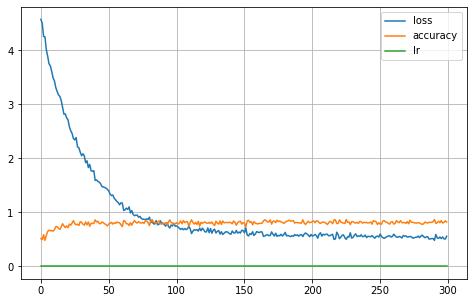

Validation montecarlo ACC: 0.8923
3/3 [==============================] - 0s 6ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9655
Validation Balanced_ACC: 0.8273
Validation Normalized MI: 0.4944
Validation Adjusted MI: 0.4847
Validation aUc: 0.9136
iteration: 8
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_8 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

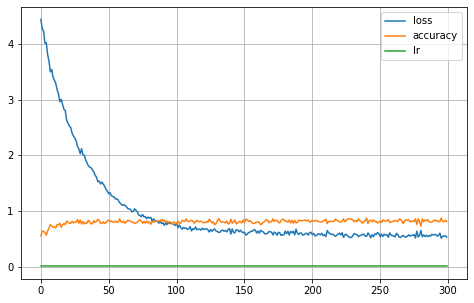

Validation montecarlo ACC: 0.9077
3/3 [==============================] - 0s 4ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9564
Validation Balanced_ACC: 0.9091
Validation Normalized MI: 0.5826
Validation Adjusted MI: 0.5750
Validation aUc: 0.9545
iteration: 9
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 13)]              0         
                                                                 
 batch_normalization_9 (Batc  (None, 13)               52        
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 13)                0         
                                                                 
 h1 (Dense)                  (None, 39)                546       
                                                    

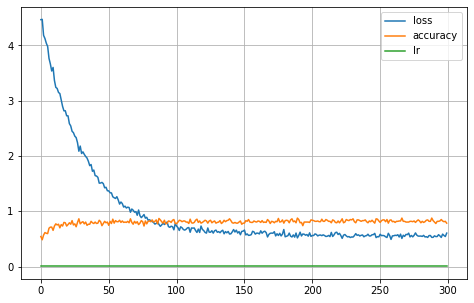

Validation montecarlo ACC: 0.9077
3/3 [==============================] - 0s 5ms/step
Validation ACC: 0.9231
Validation aUc_Sklearn: 0.9691
Validation Balanced_ACC: 0.8273
Validation Normalized MI: 0.4944
Validation Adjusted MI: 0.4847
Validation aUc: 0.9136


In [185]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =  0.01
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
    MA = Keras_MA_GCCE(epochs=300,batch_size=32,R=1, K=len(np.unique(Y_true_train)), dropout=0.2, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0, verbose=0, q=0.7)


    MA.fit(X_train, Y_true_train)
    MA.plot_history()
  

    #Accuracy montecarlo Dropout ======================
    y_pred = MA.predict_proba(X_test, 200)
    acc = accuracy_score(y_pred.argmax(axis=1),Y_true_test.ravel())
    ACC[i] = acc
    print("Validation montecarlo ACC: %.4f" % (float(acc)))
 
    #Accuracy ===============================================================
    pred_2 = MA.predict(X_test)
    report = classification_report(Y_true_test.ravel(), pred_2.argmax(axis=1),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))
 
    #AUC ================================================================================
    val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)  
    #val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).squeeze().astype('float'))
    val_AUC1 = roc_auc_score(ook(Y_true_test), pred_2)
    print("Validation aUc_Sklearn: %.4f" % (float(val_AUC1),))
    AUC[i] = val_AUC1



    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    # MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    # print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    #AUC[i] = val_AUC

In [186]:
pred_2.argmax()

95

In [187]:
y_pred = MA.predict_proba(X_test, 50)
acc = np.mean(np.round(y_pred.argmax(axis=1))  == Y_true_test.ravel())
acc

0.9076923076923077

In [188]:
ACC

array([0.92307692, 0.92307692, 0.92307692, 0.92307692, 0.92307692,
       0.93846154, 0.92307692, 0.92307692, 0.92307692, 0.92307692])

In [189]:

ACC

array([0.92307692, 0.92307692, 0.92307692, 0.92307692, 0.92307692,
       0.93846154, 0.92307692, 0.92307692, 0.92307692, 0.92307692])

In [190]:
 
AUC

array([0.96181818, 0.96545455, 0.96545455, 0.96545455, 0.96363636,
       0.96      , 0.96909091, 0.96545455, 0.95636364, 0.96909091])

# Accuracy Results

In [194]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  92.46
Average std:  0.45999999999999996
Average AUC:  96.41999999999999
Average AUC std:  0.37
Average Balanced Accuracy:  85.36
Average std:  4.05
Average MI:  0.0
Average std:  0.0
Average Normalized MI:  52.59
Average std:  4.97
Average Ajdusted MI:  51.68000000000001
Average std:  5.08


In [192]:
#MA.predict(X_test)

In [193]:
acc = np.mean(np.argmax(pred_2, axis=1)==Y_true_test.T)
acc



0.9230769230769231